<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/WDFHysteresisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary imports to configure the environment.

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
# Get the model weigths from Github
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/WD%20Models/PreisachRNNWD_12_units_seq_len_20_stateful_True_first_magnetization_False_fs_96000.0_repeated_2_sat_True.h5

In [2]:
from tensorflow.math import maximum, minimum

class PreisachMemoryLayer(tf.keras.layers.Layer):
    def __init__(self, n_operators, batch_size, stateful, input_min=-1, input_max=1, **kwargs):
        super(PreisachMemoryLayer, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.n_operators = n_operators
        
        self.first_batch = True
        self.stateful = stateful
        
        self.input_min = input_min
        self.input_max = input_max
    
    def build(self, input_shape):
        self.input_dim = input_shape

        if self.input_dim[0] == None:
            raise ValueError(f'The Preisach Layer cannot instantiate the set of Play Operators for batch_size = None.'
            + '\n Set an integer value for the batch_size.')

        self.play_operators = tf.Variable(name='PlayOperators', 
                                          initial_value=tf.zeros((input_shape[0], input_shape[1], self.n_operators)), 
                                          trainable=False)
        self.prev_play_operators = tf.Variable(name='PrevPlayOperators',
                                               initial_value=tf.zeros((input_shape[0], self.n_operators)),
                                               trainable=False) 
        self.r = np.zeros(self.n_operators)
        
        for j in range(self.n_operators):
            # Since the input signal is required to be normalized between -1 and 1,
            # the values of input_min and input_max are respectively -1 and 1.
            self.r[j] = (j / self.n_operators) * (self.input_max - (self.input_min))
        
    def call(self, inputs):
        for t in range(self.input_dim[1]):
            for j in range(self.n_operators):
                if t == 0:
                    if self.first_batch:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], 0))) 
                    else:
                        self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.prev_play_operators[:, j])))
                else:
                    self.play_operators[:, t, j].assign(maximum(inputs[:, t, 0] - self.r[j], minimum(inputs[:, t, 0] + self.r[j], self.play_operators[:, t - 1, j])))
                
        if self.first_batch and self.stateful:
            self.first_batch = False
        
        self.prev_play_operators.assign(self.play_operators[:, t, :])
        
        # The following comment is used as a reference for the Play Operators definition
        # P_j(t) = max(u(t) - r_j, min(u(t) + r_j, P_j(t - 1)))
        # P_j(0) = max(u(0) - r_j, min(u(0) + r_j, k0))
        # r_j = (j - 1)/n * (max(u(t)) - min(u(t)))  j = 1, ..., n
        return self.play_operators
    
    def reset_first_batch(self):
        self.fist_batch = True

In [6]:
class PreisachRNNModel():
    def __init__(self, filename, seq_len, pred_batch_size=1, n_operators=6, rnn_units=12, stateful=True):
        self.seq_len = seq_len
        self.pred_batch_size = pred_batch_size
        self.n_operators = n_operators
        self.rnn_units = rnn_units
        self.stateful = stateful

        # Define the Neural Network structure
        a = tf.keras.layers.Input(shape=(self.seq_len, 1,), 
                                  batch_size=self.pred_batch_size,
                                  name='u')
        a_dot = tf.keras.layers.Input(shape=(self.seq_len, 1,),
                                      batch_size=self.pred_batch_size,
                                      name='u_dot')

        preisach_layer = PreisachMemoryLayer(n_operators=self.n_operators,
                                             batch_size=self.pred_batch_size,
                                             stateful=self.stateful,
                                             name=f"PreisachMemoryLayer_{pred_batch_size}")(a)

        concatenate = tf.keras.layers.concatenate([a, a_dot, preisach_layer], 
                                                  name='Concatenate')

        recurrent_layer = tf.keras.layers.SimpleRNN(units=self.rnn_units, 
                                                    return_sequences=False,
                                                    stateful=self.stateful, 
                                                    name='RecurrentLayer')(concatenate)
        outputs = tf.keras.layers.Dense(units=1, 
                                        activation='linear', 
                                        name='OutputLayer')(recurrent_layer)
        self.network = tf.keras.Model(inputs=[a, a_dot], outputs=outputs, name='PreisachRNN')

        # Load the model pre-trained weights
        self.network.load_weights(filename, by_name=True, skip_mismatch=True)
    
    def predict(self, input):
        return self.network.predict([np.expand_dims(input, axis=0), 
                                   np.gradient(np.expand_dims(input, axis=0), axis=1)])
    def reset_states(self):
        self.network.reset_states()
        self.network.get_layer(f'PreisachMemoryLayer_{self.pred_batch_size}').reset_first_batch()

In [7]:
class HysteresisBlock():
    def __init__(self, model, seq_len, amax, amin, bmax, bmin, Z, **kwargs):
        self.model = model
        self.seq_len = seq_len
        
        # Set the saturation values
        self.amax = amax
        self.amin = amin

        self.bmax = bmax
        self.bmin = bmin
    
        # Set the port free parameter
        self.Z = Z

        # Initialize the input buffer with amax
        self.input_buffer = np.full(self.seq_len, amax)
    
    def set_Z(self, value):
        self.Z = value
    
    def set_amax(self, value):
        self.amax = value

    def set_amin(self, value):
        self.amin = value

    def set_bmax(self, value):
        self.bmax = value
    
    def set_bmin(self, value):
        self.bmin = value

    # Scale the incident wave value between -1 and 1
    def scale_input(self, a, min_value=-1, max_value=1):
        return min_value + ((a - self.amin) / (self.amax - self.amin)) * (max_value - min_value)

    # Scale the predicted value of the reflected wave between bmin and bmax
    def scale_output(self, b, min_value=-1, max_value=1):
        return self.bmin + ((b - min_value) / (max_value - min_value)) * (self.bmax - self.bmin)

    # The following method resets the RNN states, and the input buffer: to be executed
    # before each new simulation
    def reset_input_buffer(self):
        self.model.reset_states()
        self.input_buffer = np.full(self.seq_len, amax)

    # Returns the reflected wave corresponding to the current incident wave and its previous values
    def predict(self, at):
        self.input_buffer[:-1] = self.input_buffer[1:]
        self.input_buffer[-1] = at

        input = self.scale_input(self.input_buffer)
        
        return self.scale_output(self.model.predict(input))
    
    # Returns a tuple containing the corresponding Kirchhoff variables
    def get_kirchhoff_vars(self, a, b):
        return (a + b)/self.Z, (a - b)/(2 * self.Z)

In [9]:
# Set the path to the model weights
filename = '/content/PreisachRNNWD_12_units_seq_len_20_stateful_True_first_magnetization_False_fs_96000.0_repeated_2_sat_True.h5'

# Set the model's sequence length
seq_len = 20

# Hysteresis saturation values
amax = 17788.84177804138
amin = -17791.27651142069

bmax = 13010.306027917242
bmin = -13004.773152248274

Z = 23337931.03448276

preisach_model = PreisachRNNModel(filename=filename, seq_len=seq_len)

# Initialize the Neural Network Model
reluctance = HysteresisBlock(model=preisach_model, seq_len=seq_len, amax=amax, amin=amin, bmax=bmax, bmin=bmin, Z=Z)

In [10]:
a = []
# Sampling Frequency:
fs = 96e3 # or 48e3

f0 = 50

# Sampling Period:
ts = 1/fs

# Input Signals (must be same length):
stop_time = 5/f0
t = np.arange(0, stop_time, ts)

Vin1 = 250 * np.cos(2*np.pi*t*f0)
Vin2 = 250 * np.cos(2*np.pi*t*f0)

# Number of samples:
num_samples = len(t)

# Transformer Parameters (Windings of each core):
n1 = 100
n2 = 100
n3 = 50

# Resistive Parameters [Ohms]:
Rp1 = 100
Rp2 = 100
Rs = 50
Rl = 8

# Impedances
Zs1 = np.diag([0, Rs, Rl])
Zs1[0, 0] = Zs1[1,1] + Zs1[2,2]

Zs2 = np.diag([0, (n1**2)/(ts*Rp1), (n2**2)/(ts*Rp2), (n3**2)/(ts*Zs1[0, 0])])
Zs2[0, 0] = Zs2[1,1] + Zs2[2,2] +  Zs2[3,3]

# The following line was used for debub purposes (fixed linear R = 1e5 Ohm)
# Zs2[0, 0] = 1e5

# Initialization of vectors
as1 = np.zeros(3) # Waves incident to the elements
bs1 = np.zeros(3) # Waves reflected to the elements

as2 = np.zeros(4) # Waves incident to the elements
bs2 = np.zeros(4) # Waves reflected to the elements

Vout = np.zeros(len(Vin1))

# Scattering Matrices
Bs1 = np.array([[-1, 1, 1]])
Bs2 = np.array([[1, -1, -1, 1]])

Ss1 = np.eye(Bs1.shape[-1]) - 2 * (Zs1 @ Bs1.T) @ np.linalg.inv(Bs1 @ Zs1 @ Bs1.T) @ Bs1
Ss2 = np.eye(Bs2.shape[-1]) - 2 * (Zs2 @ Bs2.T) @ np.linalg.inv(Bs2 @ Zs2 @ Bs2.T) @ Bs2

def e_to_m(n, ae, am, am_old, bm_old, Ze, Zm, Zm_old):
    beta = Ze/n + n/(ts*Zm)

    return 2/beta * ae -((2*Ze/n - beta)/beta) * am - (n/(ts*Zm_old*beta)) * am_old + (n/(ts*Zm_old*beta)) * bm_old

def m_to_e(n, ae, am, am_old, bm_old, Ze, Zm, Zm_old):
    beta = Ze/n + n/(ts*Zm)

    return -((2*Ze/n - beta)/beta) * ae +  0.5 * (((2*Ze/n - beta)**2)/beta - beta) * am + (Ze/(ts*Zm_old*beta)) * am_old -(Ze/(ts*Zm_old*beta)) * bm_old

# Resetting the Network Input Buffer:
reluctance.reset_input_buffer()

# Tree Scanning
a1m_old = 0
b1m_old = 0

a2m_old = 0
b2m_old = 0

a3m_old = 0
b3m_old = 0

for n in range(num_samples):
    # Forward Scan:
    # 4th Level
    as1[0] = Ss1[0, :] @ bs1
    ae2 = Vin2[n]
    ae1 = Vin1[n]

    # 3rd Level
    bs2[3] = e_to_m(n3, as1[0], as2[3], a3m_old, b3m_old, Zs1[0, 0], Zs2[3, 3], Zs2[3, 3])
    
    bs2[2] = e_to_m(n2, ae2, as2[2], a2m_old, b2m_old, Rp2, Zs2[2, 2], Zs2[2, 2])
    
    bs2[1] = e_to_m(n1, ae1, as2[1], a1m_old, b1m_old, Rp1, Zs2[1, 1], Zs2[1, 1])

    # 2nd Level
    as2[0] = Ss2[0, :] @ bs2

    # Root Scattering
    a.append(as2[0])
    #bs2[0] = reluctance.predict(as2[0])

    # Backward Scan:
    # 2nd Level
    as2 = Ss2 @ bs2

    # 3rd Level
    bs1[0] = m_to_e(n3, as1[0], as2[3], a3m_old, b3m_old, Zs1[0, 0], Zs2[3, 3], Zs2[3, 3])
    
    be2 = m_to_e(n2, ae2, as2[2], a2m_old, b2m_old, Rp2, Zs2[2, 2], Zs2[2, 2])
    
    be1 = m_to_e(n1, ae1, as2[1], a1m_old, b1m_old, Rp1, Zs2[1, 1], Zs2[1, 1])

    # 4th Level
    as1 = Ss1 @ bs1

    a1m_old = as2[1]
    b1m_old = bs2[1]

    a2m_old = as2[2]
    b2m_old = bs2[2]

    a3m_old = as2[3]
    b3m_old = bs2[3]

    Vout[n] = (as1[2] + bs1[2])/2

In [ ]:
Zs2[0, 0]

23337931.03448276

In [ ]:
Voutspice = np.loadtxt('/content/vout.txt')

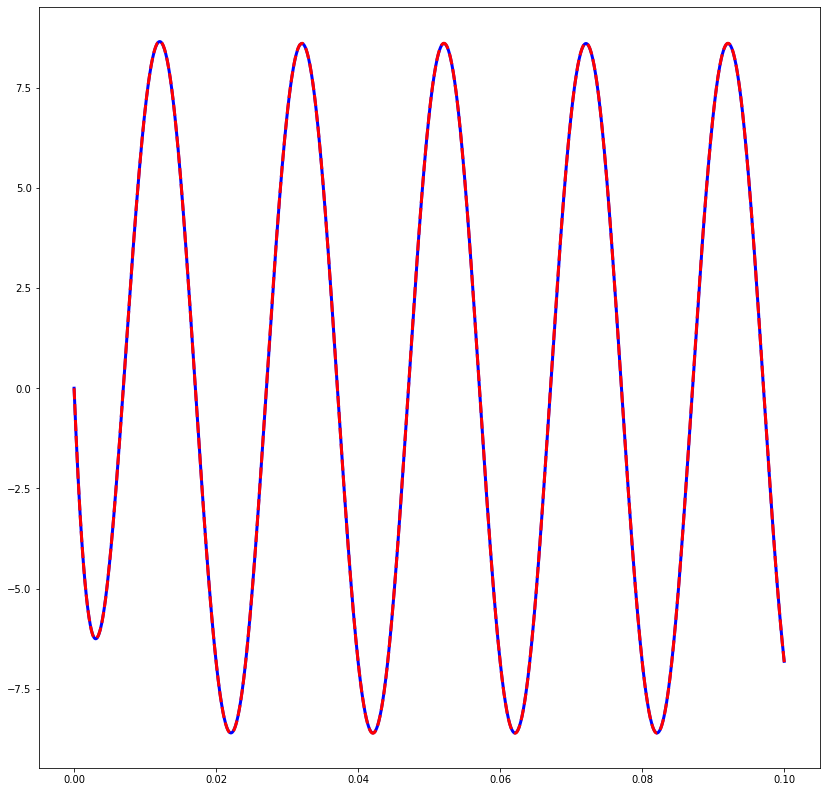

In [ ]:
# DEBUG
# Plot the voltage measured on the Load Resistance using a Linear Resistance at the Root
plt.figure(figsize=(14, 14))
plt.plot(t, Vout, 'b', linewidth=3)
plt.plot(Voutspice[:, 0], Voutspice[:, 1], 'r--', linewidth=3)

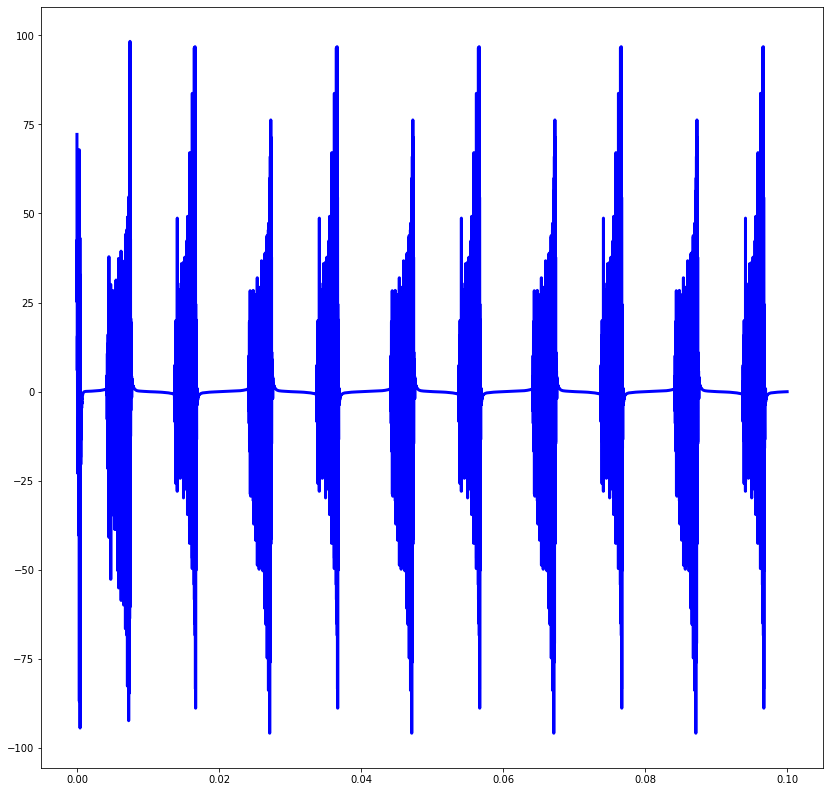

In [ ]:
# Plot the voltage measured on the Load Resistance using the Non-Linear Reluctance
plt.figure(figsize=(14, 14))
plt.plot(t, Vout, 'b', linewidth=3)

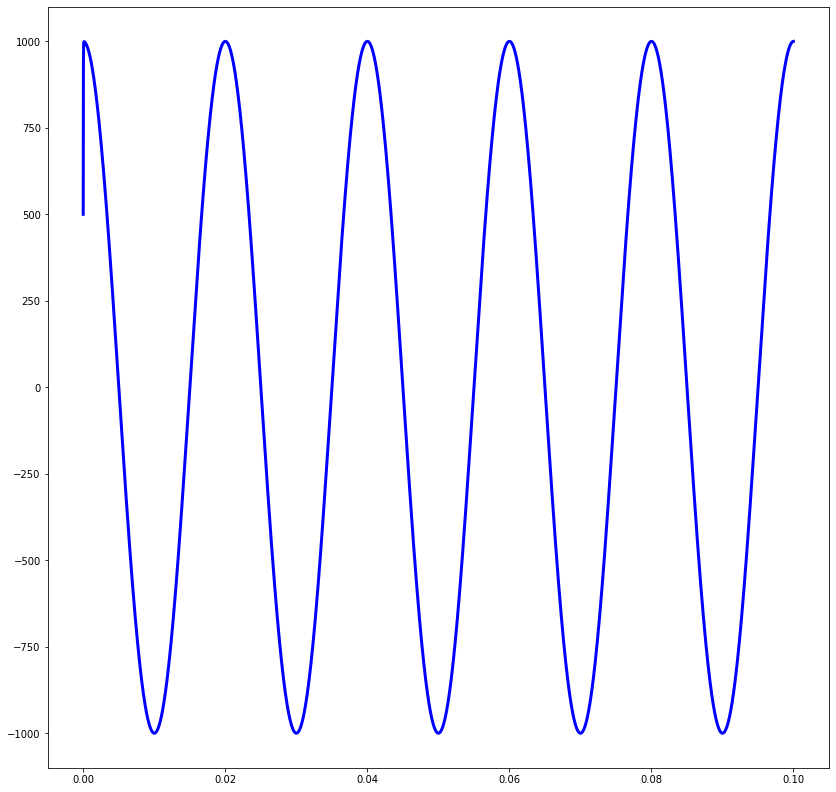

In [11]:
# Plot the incident wave to the Neural Network Model
plt.figure(figsize=(14, 14))
plt.plot(t, a, 'b', linewidth=3)